In [1]:
import pickle
import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from pathlib import Path
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from modules.action_recognizer.dataset.pose_dataset_old import PoseDataset, all_activities
from modules.action_recognizer.models.action_transformer.lit_action_transformer import LitActionTransformer
import shutil

pl.seed_everything(1234)

Seed set to 1234


1234

In [2]:
with open('output/inner_mirror_with_padding/pose_info.pkl', 'rb') as f:
    pose_info_list = pickle.load(f)
pose_info_list = sorted(pose_info_list, key=lambda x: x['index'])

with open('output/inner_mirror_with_padding/annotation.pkl', 'rb') as f:
    annotation_df = pickle.load(f)

In [3]:
# split 0
# train 1,2,3,4,6,7,8,9,10,12
# val 14, 15
# test 5, 11, 13
train_participants = [1,2,3,4,6,7,8,9,10,12]
val_participants = [14, 15]
test_participants = [5, 11, 13]
train_data = annotation_df[annotation_df.participant_id.isin(train_participants)]
val_data = annotation_df[annotation_df.participant_id.isin(val_participants)]
test_data = annotation_df[annotation_df.participant_id.isin(test_participants)]

In [4]:
train_dataset = PoseDataset(train_data, pose_info_list, max_len=30)
val_dataset = PoseDataset(val_data, pose_info_list, max_len=30)
test_dataset = PoseDataset(test_data, pose_info_list, max_len=30)

class DataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        self.train_dataset.shuffle()
        return DataLoader(self.train_dataset, batch_size=256, drop_last=True, shuffle=True, num_workers=23)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=256, num_workers=23)

    def test_dataloader(self):
        return DataLoader(test_dataset, batch_size=256, num_workers=23)
dm = DataModule(train_dataset, val_dataset, test_dataset)

In [5]:
lit_model = LitActionTransformer(
    dict(
        embed_dim=192,
        hidden_dim=256,
        num_heads=3,
        num_layers=6,
        num_classes=len(all_activities),
        num_joints=13,
        num_frames=30,
        dropout=0.3,
        is_pre_norm=False
    ),
    lr=1e-3,
    is_pose_3d=False,
)

model_checkpoint_callback = ModelCheckpoint(
    monitor='val_acc', mode='max', save_top_k=1
)
early_stopping = EarlyStopping(
    monitor='val_acc',  mode="max", patience=3
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_epoch = 300
saved_model_path = 'saved_models/action_recognizer/action_transformer_with_padding/pose_2d'
if Path(saved_model_path).exists():
    shutil.rmtree(saved_model_path)

enable_progress_bar = True
num_sanity_val_steps = 10
val_check_period = 10

trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[
        model_checkpoint_callback,
        early_stopping
    ],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0,
    logger=enable_progress_bar,
    enable_progress_bar=enable_progress_bar,
    num_sanity_val_steps=num_sanity_val_steps,
    log_every_n_steps=5,
    # reload_dataloaders_every_n_epochs=1
)

trainer.fit(lit_model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: saved_models/action_recognizer/action_transformer_with_padding/pose_2d/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | ActionTransformer | 1.5 M 
--------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.023     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

validation set accuracy = 0.0128 [correct=6/470]


Training: |                                                                                                   …

Validation: |                                                                                                 …

validation set accuracy = 0.4787 [correct=225/470]


Validation: |                                                                                                 …

validation set accuracy = 0.4766 [correct=224/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5000 [correct=235/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5277 [correct=248/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5128 [correct=241/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5574 [correct=262/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5447 [correct=256/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5383 [correct=253/470]


Validation: |                                                                                                 …

validation set accuracy = 0.5532 [correct=260/470]


In [6]:
trainer.test(lit_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

Test set accuracy = 0.5729 [correct=381/665]
Test set confusion_matrix =
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  3  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  5  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 91  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0 80  0  2  0  0  1  0  1  0  0  0  0  0  1  0  0  1  0  0  0  2  

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5729323029518127     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5729323029518127}]

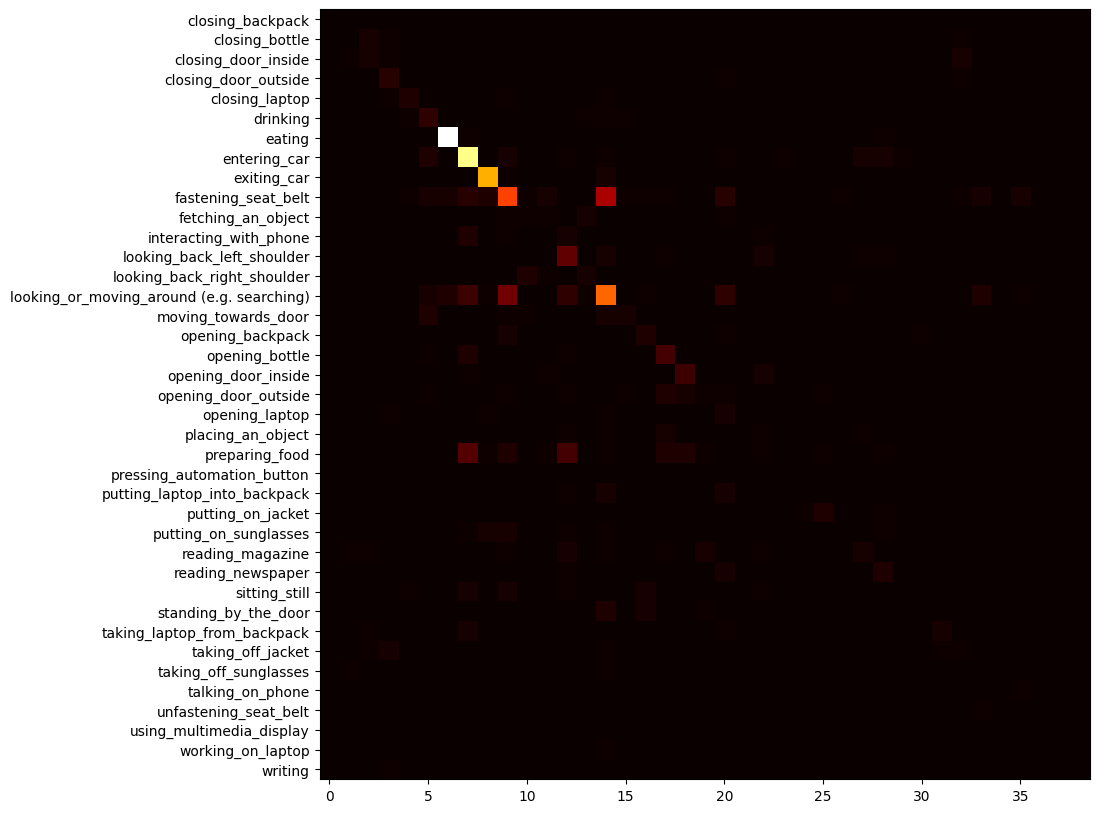

In [7]:
import matplotlib.pyplot as plt
from modules.action_recognizer.dataset.pose_dataset import all_activities
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(lit_model.test_confusion_matrix, cmap='hot', interpolation='nearest')
ax.set_yticks(range(len(all_activities)))
ax.set_yticklabels(all_activities)
plt.show()